In [1]:
!pip install -r requirements.txt

    100% |████████████████████████████████| 81kB 5.8MB/s ta 0:00:011
    100% |████████████████████████████████| 60.7MB 717kB/s eta 0:00:01
    100% |████████████████████████████████| 6.4MB 6.6MB/s eta 0:00:01   4% |█▍                              | 286kB 44.0MB/s eta 0:00:01
    100% |████████████████████████████████| 8.8MB 7.1MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 14.6MB/s ta 0:00:01
    100% |████████████████████████████████| 122kB 21.2MB/s ta 0:00:01


    100% |████████████████████████████████| 71kB 17.2MB/s ta 0:00:01
    100% |████████████████████████████████| 389kB 29.0MB/s ta 0:00:01
    100% |████████████████████████████████| 2.2MB 17.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for docopt ... done
  Stored in directory: /root/.cache/pip/wheels/9b/04/dd/7daf4150b6d9b12949298737de9431a324d4b797ffd63f526e
Successfully built docopt
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.28 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.
unityagents 0.4.0 has requirement tensorflow==1.7.1, but you'll have tensorflow 1.3.0 which is incompatible.
cupy-cuda102 9.6.0 has requirement numpy<1.24,>=1.17, but you'll have numpy 1.12.1 which is incompatible.
  Found existing installation: protobuf 3.5.1
    Uninstalling protobuf-3.5.1:
      Successfully uninstalled protobuf-3.5.1
  Found existing install

In [2]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from collections import deque
from workspace_utils import active_session
from agent import Agent
from unityagents import UnityEnvironment

In [3]:
# versão com 20 agentes do ambiente
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# obtenha o cérebro padrão
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reseta o ambiente
env_info = env.reset(train_mode=True)[brain_name]

# número de agentes
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# tamanho de cada ação
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examina o espaço de estados 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


In [6]:
env_info = env.reset(train_mode=True)[brain_name]      # reseta o ambiente   
states = env_info.vector_observations                  # obtém o estado atual (para cada agente)
scores = np.zeros(num_agents)                          # inicializa a pontuação (para cada agente)
while True:
    actions = np.random.randn(num_agents, action_size) # selecione uma ação (para cada agente)
    actions = np.clip(actions, -1, 1)                  # todas as ações entre -1 e 1
    env_info = env.step(actions)[brain_name]           # envia todas as ações para o ambiente
    next_states = env_info.vector_observations         # obtém o próximo estado (para cada agente)
    rewards = env_info.rewards                         # obtenha recompensa (para cada agente)
    dones = env_info.local_done                        # veja se o episódio terminou
    scores += env_info.rewards                         # atualize a pontuação (para cada agente)
    states = next_states                               # role os estados para a próxima etapa de tempo
    if np.any(dones):                                  # loop de saída se o episódio terminar
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.18099999595433475


In [7]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=42)

In [8]:
def ddpg(n_episodes=2000, print_every=10, max_t=1000, score_solved=30):
    """
    Parâmetros
    ======
        n_episodes (int): número máximo de episódios de treinamento
        max_t (int): número máximo de timesteps por episódio
    """
    scores_window = deque(maxlen=100)                     # pontuações médias dos episódios mais recentes
    scores = []                                           # lista de pontuações médias de cada episódio
                
    for i_episode in range(1, n_episodes+1):
        score = np.zeros(num_agents)                      # inicializar pontuação para cada agente
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()                                     # redefinir ambiente
        states = env_info.vector_observations             # obtém o estado atual de cada agente
        rewards = env_info.rewards
        for t in range(max_t):
            actions = agent.act(states)                   # selecione uma ação
            env_info = env.step(actions)[brain_name]      # envia ações para o ambiente
            next_states = env_info.vector_observations    # obtém o próximo estado
            rewards = env_info.rewards                    # obter recompensa
            dones = env_info.local_done                   # ver se o episódio terminou
            
            # salva a experiência no buffer de repetição, executa a etapa de aprendizado em um intervalo definido
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
                
            states = next_states
            score += rewards
            if np.any(dones):                             # loop de saída quando o episódio termina
                break              
            
        scores_window.append(score)                       # salvar pontuação média para o episódio
        scores.append(score)                              # salva pontuação média na janela
            
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)), end="") 
            
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= score_solved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')
            break

    return scores



In [9]:
with active_session():
    scores = ddpg()

Episode 10	Average Score: 3.3691
Episode 20	Average Score: 7.0454
Episode 30	Average Score: 10.1444
Episode 40	Average Score: 13.4168
Episode 50	Average Score: 16.9563
Episode 60	Average Score: 20.0380
Episode 70	Average Score: 22.4875
Episode 80	Average Score: 24.3858
Episode 90	Average Score: 25.8673
Episode 100	Average Score: 27.0639
Episode 109	Average Score: 30.1899
Environment solved in 109 episodes!	Average Score: 30.1899


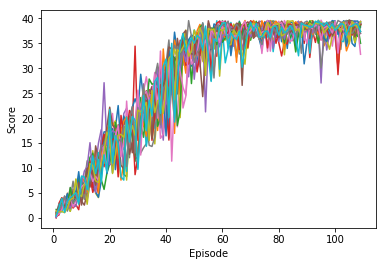

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

In [12]:
agent.actor_local.load_state_dict(torch.load('actor_checkpoint.pth'))
agent.critic_local.load_state_dict(torch.load('critic_checkpoint.pth'))

env_info = env.reset(train_mode=False)[brain_name] 
state = env_info.vector_observations               
score = np.zeros(num_agents)                       
while True:
    action = agent.act(state)                     
    env_info = env.step(action)[brain_name]        
    next_state = env_info.vector_observations  
    reward = env_info.rewards                      
    done = env_info.local_done                     
    score += reward                                
    state = next_state                            
    if np.any(done):
        break
    
print("Score: {}".format(score))

Score: [ 39.68999911  36.28999919  39.63999911  35.17999921  39.35999912
  37.76999916  37.87999915  38.74999913  39.37999912  27.44999939
  39.22999912  39.61999911  39.66999911  36.56999918  39.22999912
  39.18999912  35.52999921  38.55999914  38.13999915  36.14999919]


In [ ]:
env.close()